In [38]:
import os

In [39]:
os.environ["CUDA_VISIBLE_DEVICES"] = "1"

In [1]:
import gym
import gym.spaces
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import os

In [6]:
%matplotlib inline

# Set up

In [13]:
# set up environment
env = gym.make('CartPole-v0')

In [27]:
gamma = 0.95 # discount rate
learning_rate = 0.01
episodes = 100
epochs = 100
base_or_nah = True # baseline or not

In [15]:
state_size = 4
n_actions = env.action_space.n #number of available actions

# Create Neural Nets

In [30]:
class PolicyGradient():
    def __init__(self, learning_rate=0.01, state_size=4, action_size=2, name='PolicyGradient'):
        with tf.variable_scope(name):
            with tf.name_scope("inputs"):
                # Store Variables
                self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
                self.actions_ = tf.placeholder(tf.int32, [None, action_size], name='actions')
                self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episodes_rewards_")

            with tf.name_scope("layers"):
                # Hidden Layers
                self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 32, 
                                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 64, 
                                                             weights_initializer=tf.contrib.layers.xavier_initializer())
                self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 32, activation_fn=None, 
                                                             weights_initializer=tf.contrib.layers.xavier_initializer())
            
            with tf.name_scope("flatten"):
                # flatten to two values
                self.flatten = tf.contrib.layers.flatten(self.fc3)
                self.logits = tf.layers.dense(inputs = self.flatten, units = 2, activation = tf.nn.relu, 
                                         kernel_initializer=tf.contrib.layers.xavier_initializer_conv2d())
            
            with tf.name_scope("softmax"):
                # Output Layer
                self.action_distribution = tf.nn.softmax(self.logits)
            
            with tf.name_scope("loss"):
                # Max reward
                self.log_prob = tf.nn.softmax_cross_entropy_with_logits_v2(logits = self.logits, 
                                                                           labels = self.actions_)
                self.loss = tf.reduce_mean(self.log_prob * self.discounted_episodes_rewards_)
                self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

class Baseline():
    def __init__(self, learning_rate=0.01, state_size=4, name="Baseline"):
        with tf.variable_scope(name):

            # Store Variables
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            self.discounted_episodes_rewards_ = tf.placeholder(tf.float32, [None,], name="discounted_episodes_rewards_")

            # Hidden Layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, 10, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, 8, 
                                                         weights_initializer=tf.contrib.layers.xavier_initializer())
            self.fc3 = tf.contrib.layers.fully_connected(self.fc2, 1, activation_fn=None, 
                                                                 weights_initializer=tf.contrib.layers.xavier_initializer())

            # Define Loss
            self.loss = tf.reduce_mean(tf.square(self.fc3 - self.discounted_episodes_rewards_), name="mse")

            # Adjust Network
            self.learn = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [22]:
def discount_rewards(r, gamma = .95, normalize = False):
    """discount rewards and return a list"""
    discount_r = np.zeros_like(r)
    running_add = 0
    for t in reversed(range(len(r))):
        running_add = running_add * gamma + r[t]
        discount_r[t] = running_add      
    
    if normalize:
        mean = np.mean(discount_r)
        std = np.std(discount_r)
        discount_r = (discount_r - mean) / (std)
    
    return list(discount_r)

# Create Instances

In [31]:
tf.reset_default_graph()
CartPole = PolicyGradient(name = 'CartPole', learning_rate=learning_rate, state_size=state_size, action_size=n_actions)
baseline = Baseline(name = 'Base', learning_rate=learning_rate, state_size=state_size)

# Train network

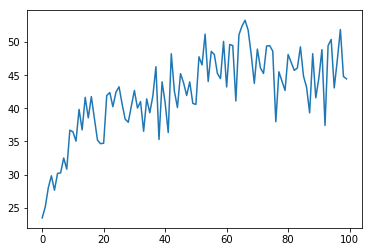

In [40]:
# Initialize the simulation
env.reset()

all_rewards = []

with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    
    for epoch in range(epochs):
        
        # save all states, actions, and rewards that happen 
        all_states, all_actions, all_discount_rewards = [], [], []
        running_rewards = []
        
        for episode in range(episodes):
            
            state = env.reset()
            episode_rewards = []
            
            while True:            
                # get action prob distribution
                action_dist = sess.run(CartPole.action_distribution, 
                                       feed_dict={CartPole.inputs_: state.reshape((1,*state.shape))})
                
                # select action per distribution
                action = np.random.choice(range(action_dist.shape[1]), p=action_dist.ravel())
                new_state, reward, done, _ = env.step(action)
                
                # record all observed values
                all_states.append(state)
                episode_rewards.append(reward)
                
                # action 0 or 1
                which_action = np.zeros(action_dist.shape[1])
                which_action[action] = 1
                all_actions.append(which_action)
                
                # reset current state to be new state
                state = new_state
                
                if done:
                    # Calculate discounted reward per episode
                    dis_rewards = discount_rewards(episode_rewards)
                    all_discount_rewards += dis_rewards
                    
                    # record reward per episode
                    running_rewards.append(sum(episode_rewards))
                    break
        
        if base_or_nah: 
            # baseline adjustment
            original_r = all_discount_rewards.copy()
            baseline_r = sess.run(baseline.fc3, feed_dict={baseline.inputs_ : np.vstack(all_states)})
            all_discount_rewards -= np.hstack(baseline_r)

            # train on baseline
            _, _= sess.run([baseline.loss, baseline.learn], 
                        feed_dict={baseline.inputs_: np.vstack(all_states),
                        baseline.discounted_episodes_rewards_: original_r })
         
        # Policy Gradient Descent Update
        _, _= sess.run([CartPole.loss, CartPole.learn], 
                                     feed_dict={CartPole.inputs_: np.vstack(all_states),
                                     CartPole.actions_: np.vstack(all_actions),
                                     CartPole.discounted_episodes_rewards_: all_discount_rewards })      
        
        # average reward per episodes in epoch
        all_rewards.append(np.mean(running_rewards))

# rewards over training epochs
plt.plot(all_rewards)